In [1]:
import sys
sys.path.append('../')

,image_name,label,path,train,label_id,image_id
0,image25107.jpg,apparel,images/apparel/image25107.jpg,True,9,0
1,image26799.jpg,apparel,images/apparel/image26799.jpg,True,9,1
2,image23088.jpg,apparel,images/apparel/image23088.jpg,True,9,2
3,image0421.jpg,apparel,images/apparel/image0421.jpg,True,9,3


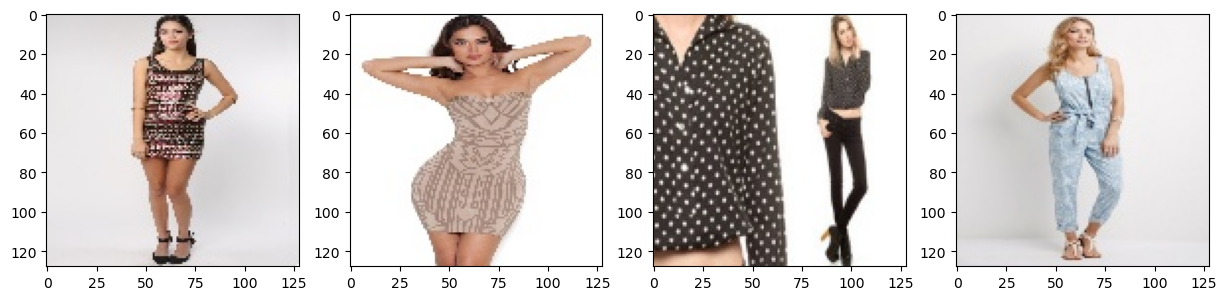

In [2]:
import cv2                      # Image Ops
import pandas as pd             # Other
import numpy as np              # Mat Opts
import matplotlib.pyplot as plt # Show Images

from utils.utils import load_images
from utils.features import load_features, save_features, extract_features
from utils.matching import minmin_retrival, match_all_images
from utils.scoring import calculate_metrics

image_meta, images = load_images(True) # True - Train Images
display(image_meta.head(4))

_, ax = plt.subplots(1, 4, figsize = (15, 6))
ax[0].imshow(images[0]);
ax[1].imshow(images[1]);
ax[2].imshow(images[2]);
ax[3].imshow(images[3]);

In [3]:
def sift_descriptor(image, octaves: int = 8, thress: float = 0.1):
    orb = cv2.SIFT_create(nfeatures = 50,  nOctaveLayers = octaves, contrastThreshold = thress, edgeThreshold = 10, sigma = 1.6  )
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, descs = orb.detectAndCompute(img, None)
    return descs

# Convertir las imágenes a escala de grises y aplicar SIFT en el subconjunto de imágenes
descriptors, index = extract_features(sift_descriptor, images, min_features=3, progress = True)
print("Tamaño de  descriptores:", descriptors.shape[1])
print("Número de  descriptores:", descriptors.shape[0])
print("Número Máximo de Descriptores Por Imágen :", pd.value_counts(index).max())
print("Número Medio  de Descriptores Por Imágen :", pd.value_counts(index).mean().round(0).astype(int))
print("Número Mínimo de Descriptores Por Imágen :", pd.value_counts(index).min())

# Obligatorio Siempre Guardar
save_features(descriptors, index, image_meta, "SIFT")

  0%|          | 0/550 [00:00<?, ?it/s]

Tamaño de  descriptores: 128
Número de  descriptores: 25405
Número Máximo de Descriptores Por Imágen : 53
Número Medio  de Descriptores Por Imágen : 47
Número Mínimo de Descriptores Por Imágen : 3


In [4]:
desc_meta, descriptors = load_features("../features/SIFT.csv") # Siempre Cargar
display(desc_meta.head())
display(descriptors.dtype)

,image_id,label_id
0,0,9
1,0,9
2,0,9
3,0,9
4,0,9


dtype('float32')

,image_name,label,path,train,label_id,image_id
0,image6479.jpg,apparel,images/apparel/image6479.jpg,False,9,0
1,image2791.jpg,apparel,images/apparel/image2791.jpg,False,9,1
2,image9608.jpg,apparel,images/apparel/image9608.jpg,False,9,2
3,image26288.jpg,apparel,images/apparel/image26288.jpg,False,9,3


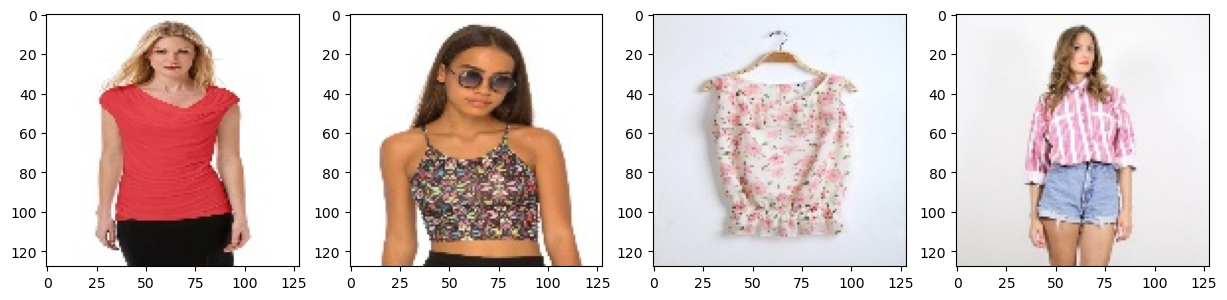

In [5]:
test_meta, test_images = load_images(False)

display(test_meta.head(4))

_, ax = plt.subplots(1, 4, figsize = (15, 6))
ax[0].imshow(test_images[0]);
ax[1].imshow(test_images[1]);
ax[2].imshow(test_images[2]);
ax[3].imshow(test_images[3]);


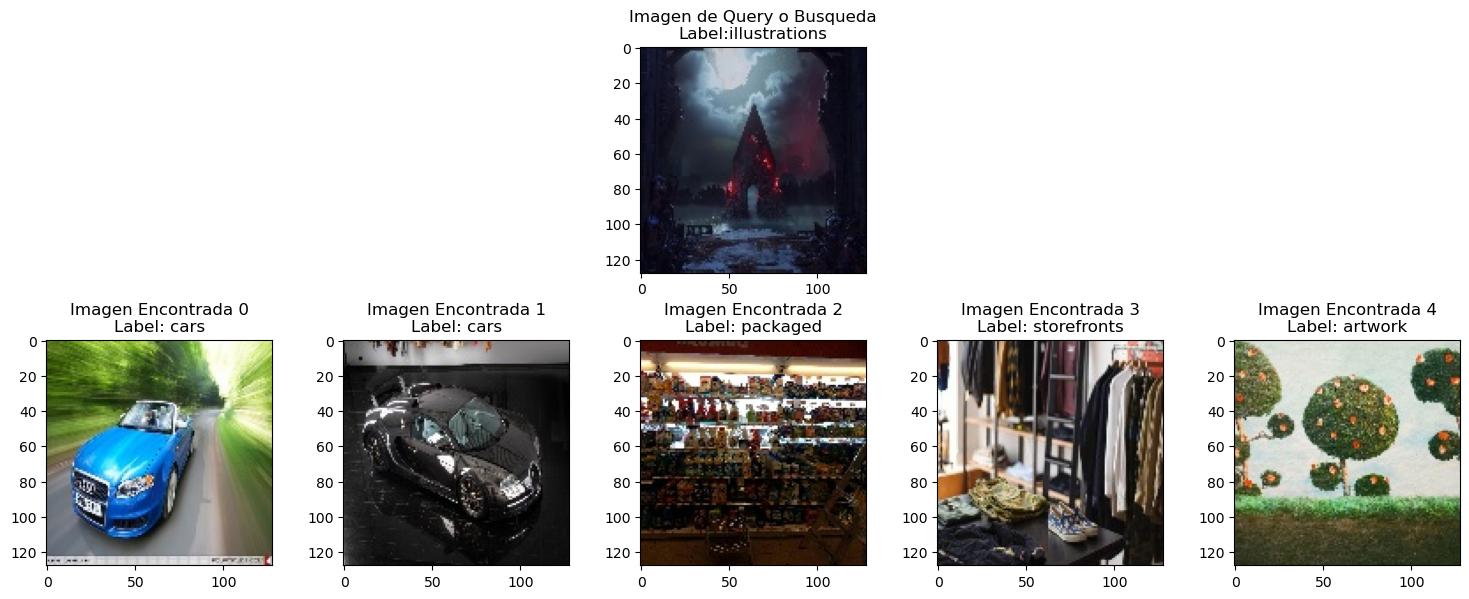

In [6]:
img = test_images[50]
descs = sift_descriptor(img)
ret_idx = minmin_retrival(descs, descriptors, desc_meta, best_k=5)

fig, ax = plt.subplots(2, 5,  figsize = (15, 6))

test_img = 50
ax[0][2].imshow(img)
ax[0][2].set_title("Imagen de Query o Busqueda\nLabel:" + test_meta.loc[test_img, 'label'])
for i, img_id in enumerate(ret_idx[:5], start = 0):
    ax[1][i].imshow(images[img_id])
    label = image_meta.loc[img_id, 'label']
    ax[1][i].set_title(f"Imagen Encontrada {i}\nLabel: {label}");

fig.delaxes(ax[0][0])
fig.delaxes(ax[0][1])
fig.delaxes(ax[0][3])
fig.delaxes(ax[0][4])

fig.tight_layout()


  0%|          | 0/110 [00:00<?, ?it/s]

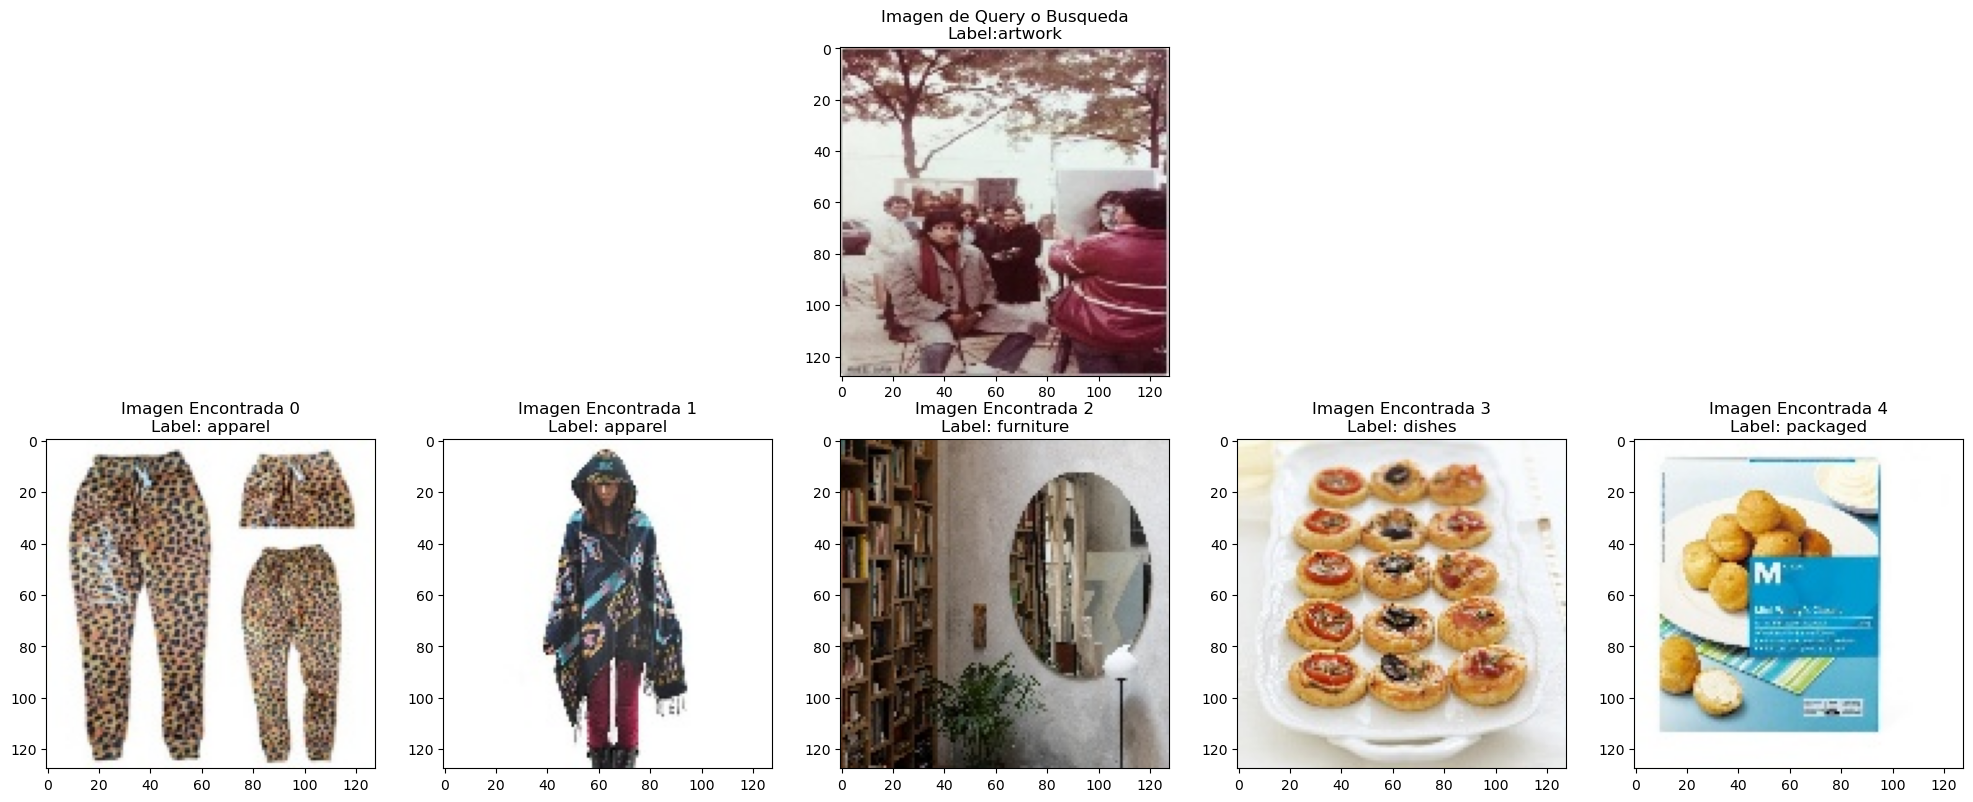

In [7]:
test_decs, test_desc_meta = extract_features(sift_descriptor, test_images, progress=True)

xr = match_all_images(test_decs, test_meta, descriptors, desc_meta, best_k=10, distance_function=cv2.NORM_L1)
fig, ax = plt.subplots(2, 5,  figsize = (20, 8))

test_img = 10
ax[0][2].imshow(test_images[test_img])
ax[0][2].set_title("Imagen de Query o Busqueda\nLabel:" + test_meta.loc[test_img, 'label'])
for i, img_id in enumerate(xr[test_img][:5], start = 0):
    ax[1][i].imshow(images[img_id])
    label = image_meta.loc[img_id, 'label']
    ax[1][i].set_title(f"Imagen Encontrada {i}\nLabel: {label}");

fig.delaxes(ax[0][0])
fig.delaxes(ax[0][1])
fig.delaxes(ax[0][3])
fig.delaxes(ax[0][4])

fig.tight_layout()


In [8]:
calculate_metrics(xr, image_meta, test_meta, scores = (1, 5, 10))

,Precision@K,Recall@K,R-Precision@K
K,,,
1,0.100000,0.002000,0.100000
5,0.101818,0.010182,0.101818
10,0.095455,0.019091,0.095455


100%|██████████| 18/18 [01:35<00:00,  5.32s/it]


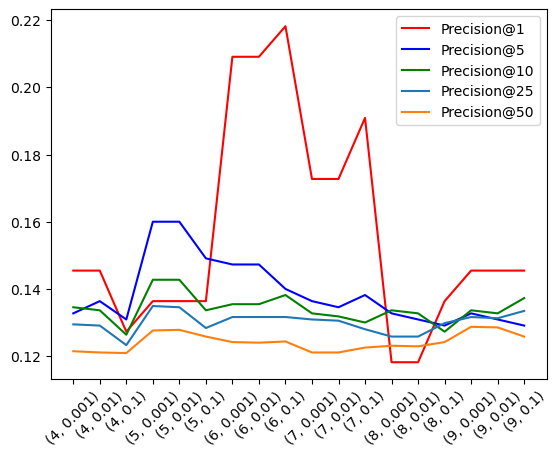

In [9]:
from tqdm import tqdm
from functools import partial
from itertools import product

rprecision1 = []
rprecision5 = []
rprecision10 = []
rprecision25 = []
rprecision50 = []
params = list(product(range(4, 10), [0.001, 0.01, 0.1]))
for par in tqdm(params):
    sift_descriptor_func = partial(sift_descriptor, octaves = par[0], thress = par[1]) 

    train_desc, train_index = extract_features(sift_descriptor_func, images)
    test_desc , test_index  = extract_features(sift_descriptor_func, test_images)

    results = match_all_images(test_desc, test_index, train_desc, train_index, best_k=50, distance_function=cv2.NORM_L2)
    rprecision = calculate_metrics(results, image_meta, test_meta, scores = (1, 5, 10, 25, 50))

    rprecision1.append( rprecision.loc[ 1, 'Precision@K'])
    rprecision5.append( rprecision.loc[ 5, 'Precision@K'])
    rprecision10.append(rprecision.loc[10, 'Precision@K'])
    rprecision25.append(rprecision.loc[25, 'Precision@K'])
    rprecision50.append(rprecision.loc[50, 'Precision@K'])

plt.plot(range(len(params)), rprecision1 , 'r', label = "Precision@1")
plt.plot(range(len(params)), rprecision5 , 'b', label = "Precision@5")
plt.plot(range(len(params)), rprecision10, 'g', label = "Precision@10")
plt.plot(range(len(params)), rprecision25,      label = "Precision@25")
plt.plot(range(len(params)), rprecision50,      label = "Precision@50")
plt.xticks(ticks = range(len(params)), labels = params, rotation = 45)
plt.legend(bbox_to_anchor = (1, 1))
plt.show()